In [230]:
import os
import getpass
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
import functools
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS, Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores.faiss import DistanceStrategy

In [64]:
llm = ChatOpenAI(model="gpt-4", streaming=True)

In [109]:
loader = PyPDFLoader("machine_learning_basics.pdf")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

store = FAISS.from_documents(docs, OpenAIEmbeddings(), distance_strategy=DistanceStrategy.COSINE)

retriever = store.as_retriever(search_kwargs={"k": 3})

### Defining Agent State

In [319]:
class ChatMessage(object):

    def __init__(self, message : BaseMessage, sender : str = None):

        self.message = message
        self.sender = sender

        self.content = message.content

    def __repr__(self) -> str:
        
        return f"{self.sender} | {self.content}"

def reducer(a : list, b : list | str ) -> list:

    if type(b) == list: 
        return a + b
    else:
        return a

    
class AgentState(TypedDict):
    messages: Annotated[Sequence[ChatMessage], reducer]


In [440]:
USER_SYSTEM_PROMPT = """You are a translator. Translate the text provided by the user into {user_language}. Output only the 
    translated text. If the text is already in {user_language}, return the user's text as it is.
"""

AYA_AGENT_PROMPT = """Your name is Aya and you are an assistant that answers questions. Only respond if the question is addressed to you (Aya)!! 
If its not specifically addressed to you, respond with 'NULL'.
    

    Obey the following rules while responding : 
    1. Only use the text provided in the context to answer the question.
    2. If you don't know the answer, just say that you don't know. 
    3. Use three sentences maximum and keep the answer concise.
    
    Question: {question} 
    Context: {context} 
    Answer:
"""

SUPERVISOR_AGENT_PROMPT = """
You are a supervisor tasked with managing the chat messages with Aya, an AI assistant. Given a chat
message, identify whether the message was directed to Aya. If so, respond with 'Aya'. Otherwise, 
respond with 'User'

Chat Message : {message}
"""

# AYA_AGENT_PROMPT = """
# You are an assistant and your name is Aya. Only answer questions that are addressed to you (Aya). If they are not addressed to you, just respond with "Null". Based on the above instructions answer the following question : 

# Question : {question}
# Context : {context}
# Answer : 
# """


class UserAgent(object):

    def __init__(self, llm, user_language):
        self.llm = llm
        self.user_language = user_language
        self.chat_history = []

        system_prompt = USER_SYSTEM_PROMPT.format(user_language = user_language)
    
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system", system_prompt,
                ),
                MessagesPlaceholder(variable_name = 'user_text'),
            ]
        )

        self.chain = prompt | llm


    def set_graph(self, graph):
        self.graph = graph

    def send_text(self,text, debug = False):

        message = ChatMessage(message = HumanMessage(content=text), sender = self.user_language)

        inputs = {"messages": [message]}
        output = self.graph.invoke(inputs, debug = debug)
        
        return output

    def display_chat_history(self, content_only = False):

        for i in self.chat_history:
            if content_only == True:
                print(f"{i.sender} : {i.content}")
            else:
                print(i)

    
    def invoke(self, message:ChatMessage):
        
        # translated_message = self.chain.invoke({'user_text':[message.message]})
        output = self.chain.invoke({'user_text':[message]})

        # return ChatMessage(translated_message, sender = message.sender)
        return output
            


def format_docs(docs):
    return "\n\n ------------".join(doc.page_content for doc in docs)
    
class AyaAgent(object):

    def __init__(self, llm, retriever):

        self.llm = llm
        self.retriever = retriever

        qa_prompt = ChatPromptTemplate.from_template(AYA_AGENT_PROMPT)

        self.chain = qa_prompt | llm 

    def invoke(self, question : str) -> AIMessage:

        print("Within aya agent")
        print(question)

        context = format_docs(self.retriever.invoke(question))
        rag_output = self.chain.invoke({'question':question, 'context':context})
        answer = rag_output

        return answer
          
class SupervisorAgent(object):

    def __init__(self):

        prompt = ChatPromptTemplate.from_template(SUPERVISOR_AGENT_PROMPT)
    
        self.chain = prompt | llm

    def invoke(self, message : str) -> str:

        print("Within supervisor agent")
        print(message)

        output = self.chain.invoke(message)
        
        return output.content
    
       

        


In [441]:
# supervisor_agent.invoke("Aya, whats the capital of India?")

# aya_agent.invoke("Aya, When was SVM invented?")

### Defining Agent Nodes

In [442]:
def get_aya_node(state, agent, name):

    # print(f"AYA NODE : {len(state['messages'])}")

    latest_message = state["messages"][-1]
    # print(f"AYA STATE: {latest_message}")

    supervisor_agent = SupervisorAgent()
    
    agent_check = supervisor_agent.invoke(latest_message.content)

    if agent_check == 'Aya':
        # print("Agent check is Aya")

        result = agent.invoke(latest_message.content)

        return {
        'messages' : [ChatMessage(result, sender = 'Aya')]
    }
                              
    else:
        # print("Agent check is NULL")
        return {'messages':[]}
        

def get_user_node(state, agent, name):
    # print(f"USER NODE : {name}  {len(state['messages'])}")
    
    # latest_message : ChatMessage
    latest_message = state["messages"][-1]
    # print(f"USER STATE: {latest_message}")

    result = agent.invoke(latest_message.message)

    # Append the translated result with the sender info
    agent.chat_history.append(ChatMessage(result, sender = latest_message.sender))

    return {
        "messages": [],
    }

    # return {
    #     "messages": [ChatMessage(result, sender = name)],
        
    # }

def get_supervisor_node(state, agent : SupervisorAgent):

    # print(f"SUPERVISOR NODE : {len(state['messages'])}")
    latest_message = state["messages"][-1]
    # print(f"SUPERVISOR STATE: {latest_message}")

    
    

    # result = agent.invoke(latest_message.content)

    # print(result)

    return {'messages': []} 


french_agent = UserAgent(llm, "French")
spanish_agent = UserAgent(llm, "Spanish")
english_agent = UserAgent(llm, "English")

aya_agent = AyaAgent(llm, retriever)

supervisor_agent = SupervisorAgent()

french_node = functools.partial(get_user_node, agent=french_agent, name="French")
spanish_node = functools.partial(get_user_node, agent=spanish_agent, name="Spanish")
english_node = functools.partial(get_user_node, agent=english_agent, name="English")

aya_node = functools.partial(get_aya_node, agent = aya_agent, name ="Aya")

supervisor_node = functools.partial(get_supervisor_node, agent = supervisor_agent)

In [443]:
workflow = StateGraph(AgentState)

agentList = {'French':{'node':french_node, 'agent':french_agent},
                   'Spanish':{'node':spanish_node, 'agent':spanish_agent},
                   'English':{'node':english_node, 'agent':english_agent},
                   }

# agentList = {
#                    'English':{'node':english_node, 'agent':english_agent},
#                    }
                  

#Defining nodes
for agent in agentList:
    workflow.add_node(agent, agentList[agent]['node'])

workflow.add_node("Supervisor", supervisor_node)

#Defining edges
workflow.add_edge(START, "Supervisor")

for agent in agentList:
    workflow.add_edge("Supervisor", agent)
    workflow.add_edge(agent, END)


workflow.add_node("Aya",aya_node) 

def router2(state) :
    
    
    last_message = state["messages"][-1]
    if last_message.sender == "Aya":
        # print("router2 output : END")
        return "END"
    else:
        # print("router2 output : Aya")
        return 'Aya'

workflow.add_conditional_edges("Supervisor", router2  ,{'Aya':'Aya','END':END})

def router(state) :
    # print("Within router1")
    
    last_message = state["messages"][-1]
    if last_message.sender == "Aya":
        # print("router output : Supervisor")
        return "Supervisor"
    else:
        # print("router output : END")
        return 'END'
        
workflow.add_conditional_edges("Aya", router, {'Supervisor':'Supervisor','END':END})
   
# supervisor_router = functools.partial(router, agent = supervisor_agent)

# workflow.add_conditional_edges("Supervisor", supervisor_router, {"Aya": "Aya", "skip": END})


app = workflow.compile()

french_agent.set_graph(app)
spanish_agent.set_graph(app)
english_agent.set_graph(app)

In [444]:
english_agent.send_text("Hey everyone!")

Within supervisor agent
Hey everyone!


{'messages': [English | Hey everyone!]}

In [445]:
spanish_agent.send_text("Ey. Lo estoy haciendo bien")

Within supervisor agent
Ey. Lo estoy haciendo bien


{'messages': [Spanish | Ey. Lo estoy haciendo bien]}

In [446]:
english_agent.send_text("Aya, when was SVM invented?")

Within supervisor agent
Aya, when was SVM invented?
Within aya agent
Aya, when was SVM invented?


{'messages': [English | Aya, when was SVM invented?,
  Aya | Support Vector Machines (SVMs) were invented by researchers at AT&T in 1992.]}

In [405]:
english_agent.send_text("How are you guys doing today?")

SUPERVISOR NODE : 1
SUPERVISOR STATE: English | How are you guys doing today?
router2 output : Aya
USER NODE : English  1
USER STATE: English | How are you guys doing today?
AYA NODE : 1
AYA STATE: English | How are you guys doing today?
Within supervisor agent
How are you guys doing today?
Agent check is NULL
Within router1
router output : END


{'messages': [English | How are you guys doing today?]}

In [447]:
english_agent.display_chat_history(content_only=True)

English : Hey everyone!
Spanish : Hey. I'm doing it right.
English : Aya, when was SVM invented?
Aya : Support Vector Machines (SVMs) were invented by researchers at AT&T in 1992.


In [448]:
spanish_agent.display_chat_history(content_only=True)

English : ¡Hola a todos!
Spanish : Ey. Lo estoy haciendo bien
English : Aya, ¿cuándo se inventó SVM?
Aya : Las Máquinas de Vectores de Soporte (SVMs) fueron inventadas por investigadores de AT&T en 1992.


In [449]:
french_agent.display_chat_history(content_only=True)

English : Salut tout le monde!
Spanish : Ey. Je le fais bien
English : Aya, quand le SVM a-t-il été inventé?
Aya : Les Machines à Vecteurs de Support (SVMs) ont été inventées par des chercheurs d'AT&T en 1992.


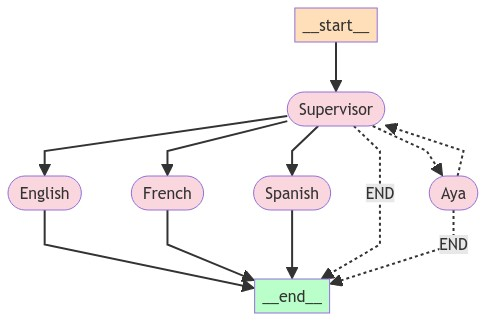

In [415]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)